# Up and Running with TensorFlow
page 229<br>
See
- https://github.com/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb,
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.allclose.html,
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html,
- https://www.tensorflow.org/api_docs/python/tf/matmul,
- https://en.wikipedia.org/wiki/Automatic_differentiation,
- https://www.tensorflow.org/guide/summaries_and_tensorboard, and
- https://www.youtube.com/watch?v=eBbEDRsCmv4 for details.

TensorFlow is a software by Google that allows the user to define a machine learning program structure and to run this structure efficiently in optimized C++ code. Parallelization to GPUs and CPUs is also possible. 
- It runs on Mac, Windows, and Linux.
- It is compatible with Scikit-Learn.
- It supports the use of many interesting APIs / packages (see e.g. page 231).
- High flexibility: any neural network architecture can be constructed.
- Highly efficient C++ implementation.
- Automatically takes care of calculating gradients via "automatic differentiation" (or "autodiff").
- The network structure can be visualized with its "TensorBoard".
- Continuous development, cloud services, "tensorflow.js", etc. keep TensorFlow at the cutting edge.

### Creating Your First Graph and Running It in a Session

In [1]:
# import tensorflow
import tensorflow as tf
# declare variables
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
# declare a function
f = x*x*y + y + 2
f
# until now, no calculation has been executed

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

<tf.Tensor 'add_1:0' shape=() dtype=int32>

The above code does not actually calculate anything! Although in particular the last line looks like it is performing a mathematical calculation, all the above code does is to create a compuational graph. Even the variables "x" and "y" are in fact not initialized, yet! In order to run the calculation that is represented by the graph, one has to establish a session and run it as follows.

In [2]:
# open a session
sess = tf.Session()
# initialize the variables (probably, this means that some memory is associated to them)
sess.run(x.initializer)
sess.run(y.initializer)
# run the function f in the session and store the outcome in result
result = sess.run(f)
# print the result
print(result)
# close the session
sess.close()

42


The below code is equivalent and a bit quicker to type because inside the "with" block the session remains throughout and is closed at the end.

In [3]:
# shorten the code by using a "with" block so "sess" can be spared inside the block (less typing to do for the ...
with tf.Session() as sess: # ... programmer
    x.initializer.run()    # intialize x
    y.initializer.run()    # intialize y
    print(f.eval())        # evaluate f and print the result (still inside the session block)

42


Instead of initializing every variable manually, initialization can be achieved globally with a node that performs the initialization. See the following code!

In [4]:
# declare a global initializer
init = tf.global_variables_initializer()
# as above, the "with" environment eases the programmer's job (no need to type "sess." almost everywhere) 
with tf.Session() as sess:
    # initialize everything
    init.run()
    # perform the computation
    result = f.eval()
    # print the result
    print(result)

42


Yet another possibility for simplifying the code is to use an "InteractiveSession". It automatically sets itself as the default session and thus requires no manual initialization of variables. However, manual closure at the end of the run is still required.

In [5]:
# this is even shorter (but it might interfere with other sessions, so pay caution if other sessions are open)
sess = tf.InteractiveSession()
# as above, initialize and run everything, then print the result
init.run()
rsult = f.eval()
print(result)
# the downside of omitting the "with" environment is that such environment (or actually its end) cannot indicate ...
# ... the end of the session; so it needs to be closed manually
sess.close()

42


As long as no other session aside the default session from "InteractiveSession" is required, the last option above seems to be the most useful option: it requires no manual initialization of variables and avoids (possibly disturbing) indentation. Only manual closing is required.<br><br>
Typically, a TensorFlow program consists of two parts: (i) first, it creates a graph that represents the model and its detailed computation steps and (ii) second, it runs a loop repeatedly for training, thus gradually improving its model parameters.
## Managing Graphs
page 234<br>
Every node that is created will automatically be added to the default graph.

In [6]:
x1 = tf.Variable(1)                # declare the variable x1
x1.graph is tf.get_default_graph() # check if it is part of the default graph: yes, it is

True

There is nothing wrong with the default graph. But if one wants to add a variable (now "x2") to another graph, this can be done by temporarily turning that other graph into the default graph.

In [7]:
graph = tf.Graph()                        # new graph
with graph.as_default():                  # the new graph is the default graph inside this "with" environment
    x2 = tf.Variable(2)                   # add the variable "x2" and end the environment
print(x2.graph is graph)                  # check if "x2" is part of "graph": yes, it is
print(x2.graph is tf.get_default_graph()) # check if "x2" is part of the default graph: no, it is not

True
False


**Suggestion or Tip**<br>
In Jupyter (or in a Python shell), it is common to run the same commands more than once while you are experimenting. As a result, you may end up with a default graph containing many duplicate nodes. One solution is to restart the Jupyter kernel (or the Python shell), but a more convenient solution is to just reset the default graph by running "tf.reset_default_graph()".
## Lifecycle of a Node Value
page 235<br>
TensorFlow automatically checks on which nodes another node depends. Then, these nodes will be run before the dependent node. This is illustrated by the following code.

In [8]:
w = tf.constant(3)         # node with a constant value
x = w + 2                  # another node, dependent on "w"
y = x + 5                  # another node, dependent on "x"
z = x * 3                  # another node, also dependent on "x"
with tf.Session() as sess: # run everything inside a "with" environment
    print(y.eval())        # 10
    print(z.eval())        # 15

10
15


The above outputs are as expected: the dependent nodes have been run first. Otherwise, the results would be different. **Importantly**, TensorFlow does not reuse the "old" results for "w" and "x", which has already been calculated for "y". Instead, it evaluates "w" and "x" twice. All node values are dropped when the graph has been run. Only variables (and partially also queues and readers, see Chapter 12) are maintained beyond the end of the graph. A variable is "born" when it is initialized and "dies" when its session is closed.<br>
Evaluating "w" and "x" twice is inefficient. To avoid such inefficiency, one can calculate "y" and "z" in one go, i.e., with one and the same graph as follows.

In [9]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val) # 10
    print(z_val) # 15

10
15


**Warning / caution**<br>
In single-process TensorFlow, multiple sessions do not share any state, even if they reuse the same graph (each session would have its own copy of every variable). In distributed TensorFlow (see Chapter 12), variable state is sotred on the servers, not in the sessions, so multiple sessions can share the same variables.
## Linear Regression with TensorFlow
page 235<br>
TensorFlow operations - or "ops" for short - can handle (almost) any number of inputs and outputs. It handles these inputs and outputs in the form of **tensors** (hence the name "TensorFlow"), i.e., multidimensional arrays. They are very similar to NumPy arrays or NumPy ndarrays, e.g., they also have a type and shape. They may carry floats or strings. Operations on the tensors like taking the transpose or multiplying them are rather intuitive. For a specific example, there is a link to TensorFlow's API documentation for "tf.matmul" at the top of this notebook. (There is also a link to the documentation on NumPy's "np.c_" operation.)<br><br>
Here, we use all this to reiterate the optimization of the California Housing dataset via the Normal Equation in TensorFlow.

In [10]:
# relevant imports
import numpy as np
from sklearn.datasets import fetch_california_housing
# get the data, its shape, and add a bias input feature x_0 = 1
housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]
# declare the features as variable "x" and the target as variable "y"
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
# build the transpose of the data and use it to deduce theta via the normal equation, see Equation 4-4 on page 108
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
# until now, we have just made declarations that are necessary for the tensorflow graph ...
# ... now, we run the graph and print the resulting values for theta
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)

[[-3.7465141e+01]
 [ 4.3573415e-01]
 [ 9.3382923e-03]
 [-1.0662201e-01]
 [ 6.4410698e-01]
 [-4.2513184e-06]
 [-3.7732250e-03]
 [-4.2664889e-01]
 [-4.4051403e-01]]


## Implementing Gradient Descent
page 237<br>
Similar to our routine in Chapter 4, we now move beyond the Normal Equation to actual machine learning. First, we manually implement Batch Gradient Descent in TensorFlow. Then, we use TensorFlow's autodiff feature to compute the gradients automatically. And finally, we will use some of TensorFlow's out-of-the-box optimizers.<br><br>
**Warning / caution**<br>
When using Gradient Descent, remember that it is important to first normalize the input feature vectors, or else training may be much slower. You can do this using TensorFlow, NumPy, Scikit-Learn's StandardScaler, or any other solution you prefer. The following code assumes that this normalization has already been done.
### Manually Computing the Gradients
page 237<br>
Taking into account the above warning, we first normalize the features.

In [11]:
# import StandardScaler from Scikit-Learn and establish an instance of it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# normalize the data and then add a bias term x_0 = 1
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]
scaled_housing_data_plus_bias.shape

(20640, 9)

The following procedure should seem familiar: we have already coded Batch Gradient Descent in Chapter 4. Now, we do it with TensorFlow. Where necessary, functions (e.g., "tf.random_uniform()" or "tf.assign()") can be looked up on the TensorFlow documentation linked above.

In [12]:
# learning schedule
n_epochs = 1000
learning_rate = 0.01
# declare variables and nodes
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")  # features
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")  # target values
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta") # initialize random bias and weights
y_pred = tf.matmul(X, theta, name="predictions")                            # make predictions
error = y_pred - y                                                          # deviations from target values
mse = tf.reduce_mean(tf.square(error), name="mse")                          # cost function
gradients = 2/m * tf.matmul(tf.transpose(X), error)                         # gradient on the cost function; see ...
                                                                            # ... Equation 4-6 on page 115 and ...
                                                                            # ... own .ipynb on Chapter 4
training_op = tf.assign(theta, theta - learning_rate * gradients)           # learning step: update theta
# build global initializer (initializes all the variables)
init = tf.global_variables_initializer()
# run it!
with tf.Session() as sess:
    sess.run(init)            # run the initializer
    for epoch in range(n_epochs):
        if epoch % 100 == 0:  # print the current epoch and mean squared error every 100 steps
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op) # run the learning step
    best_theta = theta.eval() # assign the final theta to a variable outside tensorflow
# print the result
print(best_theta)  

Epoch 0 MSE = 4.280337
Epoch 100 MSE = 0.58247656
Epoch 200 MSE = 0.53001195
Epoch 300 MSE = 0.5278852
Epoch 400 MSE = 0.52692956
Epoch 500 MSE = 0.5262425
Epoch 600 MSE = 0.52574044
Epoch 700 MSE = 0.52537286
Epoch 800 MSE = 0.52510303
Epoch 900 MSE = 0.5249041
[[ 2.0685523e+00]
 [ 8.3150929e-01]
 [ 1.2610334e-01]
 [-2.5601009e-01]
 [ 2.9207098e-01]
 [-1.8531521e-03]
 [-3.9988447e-02]
 [-8.4451884e-01]
 [-8.1476104e-01]]


Done! Simple as that.
### Using autodiff
page 238<br>
Above, we have used the analytic formula given in Equation 4-6 of the book (see also code on Chapter 4) to express the gradient in a compact way. Usually, such a hands-on analytic approach should work, at least in principle. But in reality, it will not always be practical. For example the gradient (w.r.t. "a" and "b") of the following function ...

In [13]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z
print(my_func(0, 0))
print(my_func(0, 1))
print(my_func(1, 0))
print(my_func(1, 1))

0.0
0.0
2.898088625641223
-0.19869949020717656


... is very difficult to calculate analytically. (Hint given in the book: "don't even try".)<br>
Fortunately, we can simply use TensorFlow's "autodiff" feature. Apart from "reset_graph" and "gradients", the following code is exactly the same as the one for Batch Gradient Descent above.

In [14]:
# function taken from Github link above
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
# resetting the graph
reset_graph()
# code as for Batch Gradient Descent above
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# updated gradient node
gradients = tf.gradients(mse, [theta])[0]
# code as for Batch Gradient Descent above
training_op = tf.assign(theta, theta - learning_rate * gradients)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()
print(best_theta)

Epoch 0 MSE = 12.408029
Epoch 100 MSE = 0.7551966
Epoch 200 MSE = 0.5420869
Epoch 300 MSE = 0.53316975
Epoch 400 MSE = 0.53053766
Epoch 500 MSE = 0.52879685
Epoch 600 MSE = 0.52754843
Epoch 700 MSE = 0.52664953
Epoch 800 MSE = 0.52600086
Epoch 900 MSE = 0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


While not necessary for Batch Gradient Descent, the autodiff feature is going to be very useful so one more comment on it might be appropriate: "tf.gradients()" receives an operation (in this case "mse" as defined in the same block) as well as a list of variables (in this case just "theta") and then it calculated the gradient of that operation w.r.t. every variable.<br><br>
With Table 9-2, the surrounding text, and Appendix D, the book provides some more details on "main solutions to compute gradients automatically". In case this should ever become interesting (e.g., for backpropagation), consulting the book and/or the wikipedia page on *automatic differentiation* (linked at the top) might be a good starting point for digging further into the topic. Here, it is considered sufficient to note that TensorFlow uses "Reverse-mode autodiff" which computes all gradients in just $n_{\rm outputs}+1$ graph traversals. In our example, $n_{\rm outputs}=1$, since "mse" is a scalar.
### Using an Optimizer
page 239<br>
As has just been demonstrated, TensorFlow can compute the gradient efficiently. But there is even more in the box: instead of calculating the gradient, one may use a "GradientDescentOptimizer" for training. The below code is again the same as above but replaces "gradients = ..." and "training_op = ..." with other optimizing commands.

In [15]:
# code is the same as above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# replace "gradients" and "training_op"
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
# code is the same as above
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()
print(best_theta)

Epoch 0 MSE = 12.408029
Epoch 100 MSE = 0.7551966
Epoch 200 MSE = 0.5420869
Epoch 300 MSE = 0.53316975
Epoch 400 MSE = 0.53053766
Epoch 500 MSE = 0.52879685
Epoch 600 MSE = 0.52754843
Epoch 700 MSE = 0.52664953
Epoch 800 MSE = 0.52600086
Epoch 900 MSE = 0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


Works wonderfully. There are different optimizers available. Just to show off, the book also suggests the following routine, using a "MomentumOptimizer" instead of a "GradientDescentOptimizer".

In [16]:
# code is the same as above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# replace "gradients" and "training_op"
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
# code is the same as above
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()
print(best_theta)

Epoch 0 MSE = 12.408029
Epoch 100 MSE = 0.52520055
Epoch 200 MSE = 0.52433306
Epoch 300 MSE = 0.524321
Epoch 400 MSE = 0.52432114
Epoch 500 MSE = 0.5243208
Epoch 600 MSE = 0.52432054
Epoch 700 MSE = 0.52432054
Epoch 800 MSE = 0.5243205
Epoch 900 MSE = 0.5243205
[[ 2.068558  ]
 [ 0.8296182 ]
 [ 0.11875144]
 [-0.26552498]
 [ 0.3056947 ]
 [-0.00450307]
 [-0.03932622]
 [-0.89988816]
 [-0.8705434 ]]


This shall be enough. Let's move forward to the next subject.
## Feeding Data to the Training Algorithm
page 239<br>
When we want to use Mini-batch Gradient Descent instead of (full) Batch Gradient Descent, we need a way to feed the mini-batches to the algorithm. The following simple code illuminates how this can be done.

In [17]:
# reset the graph
reset_graph()
# define a placeholder node and define its output tensor's data type (necessary) and its shape (not necessary)
# here, we use a matrix with any number of rows (specified as "None") and 3 columns
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
# open a session and run it
with tf.Session() as sess:
    # evaluate B by feeding the 1x3 matrix [[1, 2, 3]] to A
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    # evaluate B by feeding the 2x3 matrix [[4, 5, 6], [ 7, 8, 9]] to A
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [ 7, 8, 9]]})
# print the results
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


**General note**<br>
You can actually feed the output of *any* operations, not just placeholders. In this case TensorFlow does not try to evalutate these operations; is uses the values you feed it.<br><br>
For **Mini-batch Gradient Descent**, we only need to tweak our above code for (full) Batch Gradient Descent slightly. Specifically, we take the code with a "GradientDescentOptimizer" and implement the following changes:
- replace variables X and y by placeholderes X and y,
- specify the batch size and infer the number of mini-batches,
- add a function that returns mini-batches of features and the according labels,
- loop through the number of mini-batches, and feed mini-batches to the placeholders while doing so.

In [18]:
# code is the same as above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
# replace previous definitions for X (features) and y (target values) by placeholders
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="x")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
# specify the batch size and infer the number of mini-batches
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
# code is the same as above
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()
# add a function that returns mini-batches of features and the according labels (taken from the Github link above)
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # random seed should be different for all mini-batches
    indices = np.random.randint(m, size=batch_size)  # returns batch_size (100) random integers between 0 and m-1
    X_batch = scaled_housing_data_plus_bias[indices] # 100 random features ...
    y_batch = housing.target.reshape(-1, 1)[indices] # ... and their corresponding target values
    return X_batch, y_batch
# code is the same as above apart from the for-loop (which now includes "sess.run") replacing the if-loop
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        # loop through the number of mini-batches
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size) # get a mini-batch, ...
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})      # ... feed it to the algorithm, and run it
        # code is the same as above
    best_theta = theta.eval()
print(best_theta)

[[ 2.0714476 ]
 [ 0.8462012 ]
 [ 0.11558535]
 [-0.26835832]
 [ 0.32982782]
 [ 0.00608358]
 [ 0.07052915]
 [-0.87988573]
 [-0.8634251 ]]


**General note**<br>
We don't need to pass the value of X and y when avalutating theta since it does not depend on either of them.
## Saving and Restoring Models
page 241<br>
Once a model is trained, the parameters should be saved. But also during training, one should regularly save them so they can be restored in case the program crashes. TensorFlow makes it quite easy to save the model:
- just create a "tf.train.Saver()" node at the end of construction (but before initialization) and
- run this node during the execution phase whenever the model shall be saved, passing it the relevant session and a path.

The below demonstration uses the code with TensorFlow's "GradientDescentOptimizer" from further above.

In [19]:
# code is the same as above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()
# construction of the graph is almost complete: finally, create a "saver" node;   step 1/3
saver = tf.train.Saver()
# code is the same as above
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        # save the model every 100 steps (code adopted from further above);       step 2/3
        if epoch % 100 == 0:
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        # code is the same as above
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    best_theta = theta.eval()
    # save the final model still within the live session                          step 3/3
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")
    # code is the same as above
print(best_theta)

Epoch 0 MSE = 12.408029
Epoch 100 MSE = 0.7551966
Epoch 200 MSE = 0.5420869
Epoch 300 MSE = 0.53316975
Epoch 400 MSE = 0.53053766
Epoch 500 MSE = 0.52879685
Epoch 600 MSE = 0.52754843
Epoch 700 MSE = 0.52664953
Epoch 800 MSE = 0.52600086
Epoch 900 MSE = 0.5255332
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


That was easy. And restoring a model is similarly easy:
- build the model (not necessary here as we still have the graph defined above) and then
- restore the variables **instead** of initializing them.

In the below code, we attribute the name "best_theta_restored" to the restored variable "theta" so we can print it outside TensorFlow. NumPy's "allclose" function checks whether all entries of two variables are equal up to a small tolerance ("all" entries should be very "close").

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
print(best_theta_restored)
np.allclose(best_theta, best_theta_restored)

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt
[[ 2.0685525e+00]
 [ 8.1063598e-01]
 [ 1.2685777e-01]
 [-2.0784083e-01]
 [ 2.4839847e-01]
 [-1.3083883e-03]
 [-3.9607048e-02]
 [-8.5861266e-01]
 [-8.2600272e-01]]


True

TensorFlow's "tf.train.Saver()" allows the user to specify which variables to save / restore and under what name. In the following example, only "theta" can be saved / restored, namely under the name "weights". In this context, it seems important to note that a variable's name specified within "tf.train.Saver()" is relevant for TensorFlow's namespace, but not necessarily for Python's namespace. See the discussion on https://stackoverflow.com/questions/33648167/why-do-we-name-variables-in-tensorflow for details.

In [21]:
# code is the same as above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()
# save only theta and save it under the name "weights"
saver = tf.train.Saver({"weights": theta})
# code is the same as above
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        # skip saving during training (otherwise, the code continues as above)
        sess.run(training_op)
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_weights.ckpt")
# skip printing "best_theta", restore it from the checkpoint, and check if restoration was successful
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_weights.ckpt")
    best_theta_restored = theta.eval()
np.allclose(best_theta, best_theta_restored)

INFO:tensorflow:Restoring parameters from /tmp/my_model_weights.ckpt


True

By default, TensorFlow's "tf.train.Saver()" also saves the graph's structure under a similarly named file with the extension ".meta" at the end. So we can reset the graph completely and then reload it instead of building it once more from scratch. That's very handy! **Once the graph has been rebuilt, one can also restore its state.** This is demonstrated below.

In [22]:
# entire code taken from Github link above
reset_graph()                                                       # notice that this resets the graph
saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta") # load the graph structure from checkpoint
theta = tf.get_default_graph().get_tensor_by_name("theta:0")        # get the graph and infer "theta" from it
with tf.Session() as sess:                                          # run a session
    saver.restore(sess, "/tmp/my_model_final.ckpt")                 # restore the graph's state
    best_theta_restored = theta.eval()                              # evaluate theta
np.allclose(best_theta, best_theta_restored)                        # check if it (almost) equals the original value

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


True

Very nice! For the moment, this shall be enough on "saving and restoring models".
## Visualizing the Graph and Training Curves Using TensorBoard
page 242<br>
Until now, we have been relying on the "print()" function to get an idea of the training progress. There is a better way: using *TensorBoard*! Feeding it some training statistics, TensorBoard will produce good-looking, interactive visualizations of training metrics (e.g., learning curves) in the web browser. If it has access to the graph used by TensorFlow, TensorBoard will also provide an interactive visualization of that. This last feature can be particularly useful to identify misconceptions in the model.<br><br>
An important step is to write the graph's definition and some training statistics into a log directory that TensorBoard can read from. A different log directory should be used for different runs because otherwise, TensorBoard will read and display all stats and graphs at once. Such visualizations might be very cluttered. A simple solution for distinguishing different runs is to include a time stamp in the log directory.<br><br>
In the code below, we implement all the necessary steps to visualize a learning metric (here: the mean squared error) and the model's graph within TensorBoard. Specifically, we
1. create a directory with a time stamp,
2. build nodes for (i) the summary and for (ii) saving that summary and the graph at the end of the construction phase,
3. save the summary and the graph every few epochs, and
4. close the "file_writer" at the end of the run.

In [23]:
# step 1
# create a directory with a time stamp
from datetime import datetime                    # import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S") # get current UTC time as a string with specified format
root_logdir = "tf_logs/9_TF"                     # this directory will in the same folder as this .ipynb notebook
logdir = "{}/run-{}/".format(root_logdir, now)   # folder with timestamp (inside the folder "tf_logs/9_TF")
print(logdir)                                    # print the total path w.r.t. the path of this .ipynb notebook
# code is the same as for Mini-batch Gradient Descent above
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="x")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
# step 2
# before initialization, build a node for the summary and a node for saving that summary and the graph
mse_summary = tf.summary.scalar('MSE', mse)                         # "mse" will be saved via "mse_summary"
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph()) # saving of the graph under "logdir"
# code is the same as for Mini-batch Gradient Descent above
init = tf.global_variables_initializer()
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
# step 3
            # every 10 epochs, save the summary and the graph (for all batches) 
            if epoch % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch}) # summary of current batch
                step = epoch * n_batches + batch_index                             # step associated to current batch
                file_writer.add_summary(summary_str, step)                         # add step and summary to file
            # code is the same as for Mini-batch Gradient Descent above
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()
# step 4
# close the file writer
file_writer.close()
# code is the same as for Mini-batch Gradient Descent above
print(best_theta)

tf_logs/9_TF/run-20190919132004/
[[ 2.0714476 ]
 [ 0.8462012 ]
 [ 0.11558535]
 [-0.26835832]
 [ 0.32982782]
 [ 0.00608358]
 [ 0.07052915]
 [-0.87988573]
 [-0.8634251 ]]


**Warning / caution**<br>
Avoid logging training stats at every single training step, as this would significantly slow down training.<br><br>
To **visualize the graph and statistics in TensorBoard**, one should do the following.
1. Open a new shell and navigate to the folder containing the folder in which the time-stamped logging directories are saved. Here, that folder would be "Hands-On-ML" (in which this notebook is also located), as it contains the folder "tf_logs/9_TF", which in turn contains all the folders with different time stamps (as specified by the above string "logdir").
2. After navigating to that folder, run "tensorboard --logdir tf_logs/9_TF/" in the shell. This is assuming that the folder containing the time-stamped logging directories is indeed "tf_logs/9_TF" (as is the case, here). Otherwise, that part of the shell command must be adapted to the actual name of the folder containing the logs.
3. Open a new browser window and navigate to "http://localhost:6006/".

Good introductions to the functionality of TensorBoard can be found in the TensorBoard link and in the YouTube link above. The full plot range of scalar quantities will be displayed if the box "Ignore outliers in chart scaling" is unchecked.<br>
The graph becomes accessible by clicking on the "GRAPHS" tab inside TensorBoard. After removing the nodes "theta", "gradients", "GradientDescent", and "random_uniform" from the main graph by right-clicking on it, the graph looks very much like the one in Figure 9-4 of the book (but still a bit different, possibly because of another TensorFlow version).
<br><br>
**Suggestion or Tip**<br>
If you want to take a peek at the graph directly within Jupyter, you can use the "show_graph()" function available in the notebook for this chapter. It was originally written by A. Mordvintsev in his great deepdream tutorial notebook (http://goo.gl/EtCWUc). Another option is to install E. Jang's TensorFlow debugger tool (https://github.com/ericjang/tdb) which includes a Jupyter extension for graph visualization (and more).
## Name Scopes
page 245<br>
When dealing with more complex models (e.g., with neural nets), the graph may contain many, many more nodes, thus producing a lot of clutter in TensorBoard's visual graph representation. To avoid such clutter, multiple nodes can be summarized under a common name via *name scopes*. These name scopes can be expanded and collapsed in TensorBoard so that the graph becomes more structured. Below, we use the above code to demonstrate the use of name scopes by summarizing "error" and "mse" in a name scope called "loss".

In [24]:
# the following code is the same as above (but skipping the import of datetime, which has been imported already)
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs/9_TF"
logdir = "{}/run-{}/".format(root_logdir, now)
print(logdir)
reset_graph()
n_epochs = 1000
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="x")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
# define "error" and "mse" inside a name scope called "loss"
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
# the following code is the same as above
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
init = tf.global_variables_initializer()
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if epoch % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    best_theta = theta.eval()
file_writer.close()
print(best_theta)
# print the name of the ops "error" and "mse" (they should now be prefixed by "loss/")
print(error.op.name)
print(mse.op.name)

tf_logs/9_TF/run-20190919132655/
[[ 2.0714476 ]
 [ 0.8462012 ]
 [ 0.11558535]
 [-0.26835832]
 [ 0.32982782]
 [ 0.00608358]
 [ 0.07052915]
 [-0.87988573]
 [-0.8634251 ]]
loss/sub
loss/mse


As the above output shows, the operations "error" and "mse" are referred to as "loss/sub" (for "substitution", as "error" is not an explicitly defined TensorFlow variable or the like) and "loss/mse". And in TensorBoard's representation of the graph, the node "loss" appears and can be expanded to reveal "error" and "mse". The graph looks very similar to Figure 9-5 in the book (but not exactly the same, possible because of a different TensorFlow version).
## Modularity
page 246<br>
We will demonstrate TensorFlow's modularity with an example of *ReLU*s. A *Rectified Lineare Unit*, or *ReLU* for short, is a function
$$h_{\vec{W},b}={\rm max}(\vec{X}\cdot\vec{w}+b,0)\,.$$
ReLUs are not necessary to demonstrate modularity but it is good to introduce them at last, as they play an important role in machine learning. The following block is not intended to produce something useful but rather to show that copy-pasting code will easily lead to failures in the code. Also, such code is hard to maintain. A common bon mot among coders is "Two or more: use a for.", where "for" means a for-loop.

In [25]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")
z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")
relu1 = tf.maximum(z1, 0., name="relu1") # building two (or more) ReLUs by copy-pasting code can easily lead to ...
relu2 = tf.maximum(z1, 0., name="relu2") # ... failures like the faulty z1 (instead of z2) in this line
output = tf.add(relu1, relu2, name="output")

So instead of using the repetitive code above, we now define a function that builds ReLUs and then run this function as often as we want. In order to display the graph in TensorBoard, we save its structure via "tf.summary.FileWriter()"

In [26]:
# very important: reset the graph
reset_graph()
# define a function that builds a ReLU
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)                      # get the shape of X
    w =tf.Variable(tf.random_normal(w_shape), name="weights") # weight matrix with the same shape as X and random ...
                                                              # components (normally distributed)
    b = tf.Variable(0.0, name="bias")                         # scalar bias term
    z = tf.add(tf.matmul(X, w), b, name="linear")             # prediction (use "linear" instead of "z" as name)
    return tf.maximum(z, 0., name="relu")                     # return the prediction if positive and 0 otherwise
# specify the number of features (n) and the feature matrix X
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
# build 5 relus and output their sum via the "print()" function
relus =[relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")
print(output)
# we use "tf_logs/9_TF/relu1" instead of "logs/relu1" as the log directory (see Github code linked above)
logdir = "tf_logs/9_TF/relu1/"
print(logdir)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Tensor("output:0", shape=(?, 1), dtype=float32)
tf_logs/9_TF/relu1/


The above code does not save any scalars etc. that TensorBoard could display but only the graph structure. Apparently, the browser tab in which TensorBoard is running needs to be closed and reopened to "update" the available graphs. But it is not necessary to shut down and restart TensorBoard via the command line.<br><br>
Once the graph is displayed (at best with all nodes inside the main graph), the structure becomes apparent. But it is a little hard to read because all nodes required for a ReLU appear 5 times. Only the first instance of a named node (e.g. "bias") is displayed under its default name while all further instances bear an index "\_i" denoting the i-th repetition (e.g. "bias_1"), see also Figure 9-6 in the book.

In [27]:
reset_graph()
def relu(X):
    with tf.name_scope("relu"):                     # define the "relu" name scope and indent the according lines
        w_shape = (int(X.get_shape()[1]), 1)
        w =tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="linear")
        return tf.maximum(z, 0., name="relu")
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus =[relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")
print(output)
logdir = "tf_logs/9_TF/relu2/"                      # save the graph in the folder "tf_logs/9_TF/relu2/"
print(logdir)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Tensor("output:0", shape=(?, 1), dtype=float32)
tf_logs/9_TF/relu2/


As the above code demonstrates, we can group all nodes of a ReLU together by using name scopes. This leads to a much simpler graph structure, see also Figure 9-7 in the book.
## Sharing Variables
page 248<br>
Iteratively adjusting many parameters is key to machine learning. Therefore, it is important to pass updated parameters (possibly many of them) around to functions (possibly also many of them) that depend on these parameters.

In [28]:
# reset the graph
reset_graph()
# define a function for ReLUs that receive "threshold" as a parameter
def relu(X, threshold):
    # put all the following in the name scope "relu"
    with tf.name_scope("relu"):
        # the following is the same as above
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        # now use the "threshold" that was passed as a parameter
        return tf.maximum(z, threshold, name="max")
# define the threshold, X, build ReLUs, and add up their results
threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")
print(relus)

[<tf.Tensor 'relu/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_1/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_2/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_3/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_4/max:0' shape=(?, 1) dtype=float32>]


The above code uses five ReLUs, all of which receive the same parameter "threshold". One could update "threshold" and the code will perfectly fine because "threshold" is passed explicitly as an argument to the "relu" function. However, this approach reaches its limits for functions that depend on many, many parameters. There are several alternatives:
- Create and maintain (update) a complete dictionary of all parameters and pass that dictionary to all the functions that depend on a parameter.
- Create a new Python class for each module. (I do not really understand this but according to the footnote on page 249, this should be the cleanest solution.)
- Use a solution (explained further below) that is apparently very popular with TensorFlow.
- Set the shared variable as an attribute of the ReLU upon its first call.

Let's try the last option first.

In [29]:
# everything is the same as above apart from those parts with extra comments
reset_graph()
def relu(X):                                                    # "threshold" is not passed as a parameter
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):                      # returns True or False
            relu.threshold = tf.Variable(0.0, name="threshold") # initialize the attribute "threshold" if necessary 
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")
threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]                             # "threshold" is not passed as a parameter
output = tf.add_n(relus, name="output")
print(relus)

[<tf.Tensor 'relu/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_1/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_2/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_3/max:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'relu_4/max:0' shape=(?, 1) dtype=float32>]


As indicated in the above list, there is a popular solution for TensorFlow. It uses the "get_variable()" function to create the variable if it does not exist yet and to reuse it if it does exist already. This is similar to the above code but now, the desired behaviour (creating or reusing the variable) is controlled by an attribute of "variable_scope()".

In [30]:
reset_graph()
def relu(X):
    with tf.variable_scope("relu", reuse=True):     # use tf.variable_scope() instead of tf.name_scope() and note ...
                                                    # ... that existing variables will be reused in following runs
        threshold = tf.get_variable("threshold")    # use "tf.get_variable()" to get "threshold"
        w_shape = (int(X.get_shape()[1]), 1)        # shape of weight matrix "w"
        w = tf.Variable(tf.random_normal(w_shape), name="weights") # random initialization of "w"
        b = tf.Variable(0.0, name="bias")                          # bias term "b"
        z = tf.add(tf.matmul(X, w), b, name="z")                   # prediction "z"
        return tf.maximum(z, threshold, name="max") # ReLU output
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X") # declare a placeholder node "X"
with tf.variable_scope("relu"):                                    # establish the variable scope "relu" which is ...
                                                                   # ... also used by "relu(X)"
    threshold = tf.get_variable("threshold", shape=(),             # in this variable scope, declare "threshold" ...
                                initializer=tf.constant_initializer(0.0)) # ... initialize it to 0 on the first ...
                                                                   # ... run and reuse it in following runs (for ...
                                                                   # ... relu(X), reuse=True in this variable scope)
relus = [relu(X) for relu_index in range(5)]        # list of 5 ReLUs
output = tf.add_n(relus, name="output")             # sum of 5 ReLUs
print(output)
logdir = "tf_logs/9_TF/relu3/"                      # save the graph in the folder "tf_logs/9_TF/relu3/"
print(logdir)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Tensor("output:0", shape=(?, 1), dtype=float32)
tf_logs/9_TF/relu3/


If the "reuse" attribute of "tf.variable_scope()" had not been set to "True" in the third line above, the code would trigger an exception upon repeated call of the "relu(X)" function since "threshold" has been initialized already in the first run. Try it out using "reuse=False" in the third line!<br><br>
** Warning / caution**<br>
Once "reuse" is set to "True", it cannot be set back to "False" within the block. Moreover, if you define other variable scopes inside this one, they will automatically inherit "reuse=True". Lastly, only variables created by "get_variable()" can be reused this way.<br><br>
**General note**<br>
Variables created using "get_variable()" are always named using the name of their "variable_scope" as a prefix (e.g., "relu/threshold"), but for all other nodes (including variables created with "tf.Variable()") the variable scope acts like a new name scope. In particular, if a name scope with an identical name was already created, then a suffix is added to make the name unique. Fore example, all nodes created in the preceding code (except the "threshold" variable) have a name prefixed with "relus_1/" to "relu_5/", as shown in Figure 9-8.<br><br>
Indeed, the above code produces a graph very similiar to the one shown in Figure 9-8. However, it is a bit unfortunate that the "threshold" variable is defined outside the function "relu(X)". This can be fixed by telling the relevant variable_scope to reuse "threshold" after its first use, as shown in the code below.

In [31]:
reset_graph()
def relu(X):
    with tf.variable_scope("relu"):                        # set the variable scope
        threshold = tf.get_variable("threshold", shape=(), # initialize "threshold"
                                    initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu") as scope:
    first_relu = relu(X)                                   # use "relu(X)" once, thus initializing "threshold" ...
    scope.reuse_variables()                                # ... and then reuse it ...
    relus = [first_relu] + [relu(X) for i in range(4)]     # ... in following calls of "relu(X)"
output = tf.add_n(relus, name="output")
print(output)
logdir = "tf_logs/9_TF/relu4/"                             # save the graph in the folder "tf_logs/9_TF/relu4/"
print(logdir)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Tensor("output:0", shape=(?, 1), dtype=float32)
tf_logs/9_TF/relu4/


Both the above code (which comes from the Github link above) and the following code (which corresponds to the last code block displayed in Chapter 9 of the book) lead to graphs very similar to Figure 9-9 in the book.

In [32]:
reset_graph()
def relu(X):
    with tf.variable_scope("relu"):                               # set the variable scope
        threshold = tf.get_variable("threshold", shape=(),        # initialize "threshold"
                                    initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [] # this list of ReLUs will be filled during the excution of the following loop
for relu_index in range(5):
    with tf.variable_scope("relu",reuse=(relu_index>0)) as scope: # reuse=False for the first ReLU but ...
        relus.append(relu(X))                                     # reuse=True for following ReLUs
output = tf.add_n(relus, name="output")
print(output)
logdir = "tf_logs/9_TF/relu5/"                                    # save the graph in the folder "tf_logs/9_TF/relu5/"
print(logdir)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Tensor("output:0", shape=(?, 1), dtype=float32)
tf_logs/9_TF/relu5/


## Exercises
page 251
### 1.-11.
Solutions are shown in Appendix A of the book and in the separate notebook *ExercisesWithoutCode*.
### 12.
Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:
- Define the graph within a "logistic_regression()" function that can be reused easily.
- Save checkpoints using a "Saver" at regular intervals during training, and save the final model at the end of training.
- Restore the last checkpoint upon startup if training was interrupted.
- Define the graph using nice scopes so the graph looks good in TensorBoard.
- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

[The following code is heavily based on the solution shown in the Github link above.]
First, let's make moons and display the data. The classes are 0 and 1 (or -1 and +1, or "negative" and "positive") and the features are simply x- and y-coordinates.

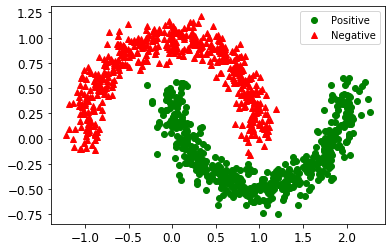

In [33]:
# make moons
from sklearn.datasets import make_moons                      # import moons
m = 1000                                                     # number of data points
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42) # make noisy dataset
# make nice pictures with matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# display the generated moons dataset (two classes)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive") # positive class (green)
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative") # negative class (red)
plt.legend()
plt.show()

As discussed in Chapter 4, Logistic Regression first employs a linear model, $\theta^{T}\cdot x$, where $x$ is a feature vector including a bias term. Then, the result of this linear model, $t$, is fed to the logistic function
$$\sigma(t)=\frac{1}{1+e^{-t}}\,.$$
So in particular, the feature vector first needs to have a bias term. Let's add it!<br>
Additionally, we shall reshape the target data into a column vector.

In [34]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons] # add a column with 1s to the feature matrix
print(X_moons_with_bias[:5])                        # show the first 5 rows of the feature matrix
print(X_moons_with_bias.shape)                      # shape of feature data
print(y_moons.shape)                                # shape of target data
y_moons_column_vector = y_moons.reshape(-1, 1)      # reshaping it
print(y_moons_column_vector.shape)                  # reshaped target data

[[ 1.         -0.05146968  0.44419863]
 [ 1.          1.03201691 -0.41974116]
 [ 1.          0.86789186 -0.25482711]
 [ 1.          0.288851   -0.44866862]
 [ 1.         -0.83343911  0.53505665]]
(1000, 3)
(1000,)
(1000, 1)


Partition the data into training and test sets, and also build a function that returns mini-batches of the training data.

In [35]:
# set size of test set
test_ratio = 0.2
test_size = int(m * test_ratio)
# training set
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
# test set
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]
# build a function that returns a mini-batch (size: "batch_size) of training data
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train),batch_size) # random indices between 0 and "test_size" (see above)
    X_batch = X_train[rnd_indices]                              # features
    y_batch = y_train[rnd_indices]                              # classes
    return X_batch, y_batch                                     # return features and classes
# try the function out for a mini-batch of size 5
X_batch, y_batch = random_batch(X_train, y_train, 5)
print(X_batch)
print(y_batch)

[[ 1.          1.93189866  0.13158788]
 [ 1.          1.07172763  0.13482039]
 [ 1.         -1.01148674 -0.04686381]
 [ 1.          0.02201868  0.19079139]
 [ 1.         -0.98941204  0.02473116]]
[[1]
 [0]
 [0]
 [1]
 [0]]


Now, it's time to build a graph for Mini-batch Gradient Descent on Logistic Regression. Here, TensorFlow has its own implementation of the sigmoid (Equation 4-14 in the book). We shall use it!

In [36]:
reset_graph()  # resetting the graph
n_inputs = 2   # number of inputs (x- and y-cooridnates, the bias term will be added "by hand" via "+1")
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1),name="X") # placeholder for data (note "n_input + 1")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")           # placeholder for classes (target values)
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta") # weight vector
logits = tf.matmul(X, theta, name="logits")                         # result of the linear model
y_proba = 1 / (1 + tf.exp(-logits))                                 # sigmoid prediction of the Logistic Regression
print(y_proba) # print this
y_proba = tf.sigmoid(logits)                                        # TensorFlow's custom sigmoid (overwrites y_proba)
print(y_proba) # print this

Tensor("truediv:0", shape=(?, 1), dtype=float32)
Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)


We also need a cost function to be minimized. As discussed in Chapter 4 (pages 135/136 of the book), the "log loss" function,
$$-log(p)\quad\text{if $y=1$},\quad-log(1-p)\quad\text{if $y=0$}\,,$$
is a good cost function for Logistic Regression. If we implement it manually, it makes sense to add a tiny term to $p$ so $log(0)$ will be avoided for $p=0$. Yet, TensorFlow has a custom implmentation for the log loss, too. So we will use that.

In [37]:
epsilon = 1e-7                                                                    # to avoid log(0) below
loss = -tf.reduce_mean(y*tf.log(y_proba+epsilon)+(1-y)*tf.log(1-y_proba+epsilon)) # manual implementation of log loss
print(loss)                                                                       # print this
loss = tf.losses.log_loss(y, y_proba)                                             # tf also uses +1e-7 by default
print(loss)                                                                       # print this

Tensor("Neg_1:0", shape=(), dtype=float32)
Tensor("log_loss/value:0", shape=(), dtype=float32)


Let's finish the TensorFlow model! It is in large parts the same as the main text above (see "Feeding Data to the Training Algorithm" / page 239 in the book).

In [38]:
learning_rate = 0.01                                                       # specify the learning rate
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # use tf's gradient descent optimizer
training_op = optimizer.minimize(loss)                                     # training operation
init = tf.global_variables_initializer()                                   # initialize the variables
# plan how data will be fed to the algorithm
n_epochs = 1000                                                            # number of epochs
batch_size = 50                                                            # batch size
n_batches = int(np.ceil(m / batch_size))                                   # number of batches
# let's run the thing in tensorflow
with tf.Session() as sess:                                                 # run a tensorflow session
    sess.run(init)                                                         # run initializer
    for epoch in range(n_epochs):                                          # epochs
        for batch_index in range(n_batches): # batches
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)  # build batch
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})      # run training step with current batch
        loss_val = loss.eval({X: X_test, y: y_test})                       # evaluate loss on the test set
        if epoch % 100 == 0:                                               # every 100 epochs ...
            print("Epoch:", epoch, "\tLoss:", loss_val)                    # ... print the loss on the test set 
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})           # prediction of the final model
# print final results
print(y_proba_val[:5])                                                     # model output
y_pred = (y_proba_val >= 0.5)                                              # class predictions
print(y_pred[:5])                                                          # print the first 5 class predictions

Epoch: 0 	Loss: 0.79260236
Epoch: 100 	Loss: 0.34346345
Epoch: 200 	Loss: 0.30754045
Epoch: 300 	Loss: 0.29288897
Epoch: 400 	Loss: 0.28533578
Epoch: 500 	Loss: 0.2804781
Epoch: 600 	Loss: 0.2780829
Epoch: 700 	Loss: 0.2761544
Epoch: 800 	Loss: 0.27551997
Epoch: 900 	Loss: 0.27491233
[[0.54895616]
 [0.70724374]
 [0.51900256]
 [0.9911136 ]
 [0.5085905 ]]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]]


For the test set, check
$${\rm precision}=\frac{\rm TP}{{\rm TP}+{\rm FP}}$$
i.e., the fraction of positively classified instances that do actually belong to the positive class and
$${\rm recall}=\frac{\rm TP}{{\rm TP}+{\rm FN}}$$
i.e., the fraction of actual positive instances that are classified positively.<br><br>
While increasing the threshold, *precision is expected to go up* as false positives should decrease. But occasionally, it can also decrease as true positives get (wrongfully) filtered out. In contrast, *recall will decrease monotonically* while increasing the threshold since its nominator (the "positive class") is fixed and the numerator can only decrease.

In [39]:
from sklearn.metrics import precision_score, recall_score # import precisison and recall scores from scikit-learn
print(precision_score(y_test, y_pred))                    # print precision score on test set
print(recall_score(y_test, y_pred))                       # print recall score on test set

0.8627450980392157
0.8888888888888888


We now visualize the predictions on the test set in a plot. The code makes use of the tilde "~" opearator. Apparently, this operator simly inverts the bits. In particular, it turns "True" into "False" and vice versa. See the contribution of user "wberry" on https://stackoverflow.com/questions/8305199/the-tilde-operator-in-python.

(200, 1)
(200,)


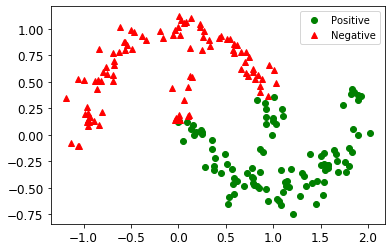

In [40]:
print(y_pred.shape)                                                              # shape of a matrix
y_pred_idx = y_pred.reshape(-1)                                                  # make the matrix a vector
print(y_pred_idx.shape)                                                          # shape of a vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")   # positives
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative") # negatives
plt.legend()                                                                     # add a legend
plt.show()                                                                       # show the plot

Well, that looks pretty bad! However, we are using a linear model, i.e., a linear decision boundary. Taking this into account, the result is actually quite good. We continue with a linear model but from now on involve higher-order polynomials in the hope that this will lead to better results. We also add all the fancy stuff mentioned in the original exercise.<br><br>
We start by adding higher polynomials.

In [41]:
X_train_enhanced = np.c_[X_train,                  # original data (including the bias term)
                         np.square(X_train[:, 1]), # squares ...
                         np.square(X_train[:, 2]), # ... without mixing
                         X_train[:, 1] ** 3,       # cubics ...
                         X_train[:, 2] ** 3]       # ... without mixing
X_test_enhanced = np.c_[X_test,                    # and the same for the features of the test set
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]
print(X_train_enhanced[:5])                        # print the first 5 instances

[[ 1.00000000e+00 -5.14696757e-02  4.44198631e-01  2.64912752e-03
   1.97312424e-01 -1.36349734e-04  8.76459084e-02]
 [ 1.00000000e+00  1.03201691e+00 -4.19741157e-01  1.06505890e+00
   1.76182639e-01  1.09915879e+00 -7.39511049e-02]
 [ 1.00000000e+00  8.67891864e-01 -2.54827114e-01  7.53236288e-01
   6.49368582e-02  6.53727646e-01 -1.65476722e-02]
 [ 1.00000000e+00  2.88850997e-01 -4.48668621e-01  8.34348982e-02
   2.01303531e-01  2.41002535e-02 -9.03185778e-02]
 [ 1.00000000e+00 -8.33439108e-01  5.35056649e-01  6.94620746e-01
   2.86285618e-01 -5.78924095e-01  1.53179024e-01]]


Let's get serious! After resetting the graph, we define a function that receives a mini-batch and possibly more arguments (e.g., an initializer), performs a training step, and returns relevant data. We also build a function that returns a time-stamped log-directory. Then we consider 6 (+1) features, get a directory for saving our model, define placeholders for feeding the data to the algorithm, implement training steps, and finally save the model.<br>Now, the graph exists. Yet until now, it has not been run, yet.

In [42]:
# reset the graph
reset_graph()
# define a function that performs a training step, makes a checkpoint, and returns relevant output.
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):                                         # name scope
        with tf.name_scope("model"):                                                   # name scope
            if initializer is None:                                                    # choose an initializer
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")                             # weights
            logits = tf.matmul(X, theta, name="logits")                                # prediction
            y_proba = tf.sigmoid(logits)                                               # mapping to interval [0,1]
        with tf.name_scope("train"):                                                   # name scope
            loss = tf.losses.log_loss(y, y_proba, scope="loss")                        # loss function
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # gradient descent optimizer
            training_op = optimizer.minimize(loss)                                     # training step
            loss_summary = tf.summary.scalar('log_loss', loss)                         # summary for records
        with tf.name_scope("init"):                                                    # name scope
            init = tf.global_variables_initializer()                                   # initialize variables
        with tf.name_scope("save"):                                                    # name scope
            saver = tf.train.Saver()                                                   # saving
    return y_proba, loss, training_op, loss_summary, init, saver                       # returned data
# define a function that returns a path for checkpoint files
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs/9_TF"
    if prefix:
        prefix += "-"
    name = prefix + "exercise-" + now
    return "{}/{}/".format(root_logdir, name)
# with quadratic and cubic (no interference terms) features, we have 4+2=6 inputs (+1 for the bias term, see X below)
n_inputs = 2 + 4
# directory for saving the model
logdir = log_dir("logreg")
print(logdir)
# define placeholders for feeding data to the algorithm
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
# perform a training step
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)
# build a file_writer via tf.summary.FileWriter
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

tf_logs/9_TF/logreg-exercise-20190919133634/


Let's run it now!

In [43]:
# remaining import
import os
# planning the mini-batches
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
# paths for saving stuff
checkpoint_path = "./tf_logs/9_TF/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./tf_logs/9_TF/my_logreg_model"
# run the graph
with tf.Session() as sess:
    # resume training where it stopped previously ...
    if os.path.isfile(checkpoint_epoch_path): # if a checkpoint exists, restore that model and load its epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    # ... or start over if no chekpoint is available
    else:
        start_epoch = 0
        sess.run(init)
    # loop through expchs
    for epoch in range(start_epoch, n_epochs):
        # loop through batches and save current model
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        # every 500 epochs, print the current epoch and update the check point
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    # save final model and delete checkpoints            
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)


Epoch: 0 	Loss: 0.629985
Epoch: 500 	Loss: 0.16122364
Epoch: 1000 	Loss: 0.1190321
Epoch: 1500 	Loss: 0.097329214
Epoch: 2000 	Loss: 0.08369793
Epoch: 2500 	Loss: 0.074375816
Epoch: 3000 	Loss: 0.06750215
Epoch: 3500 	Loss: 0.062206898
Epoch: 4000 	Loss: 0.058026794
Epoch: 4500 	Loss: 0.054562975
Epoch: 5000 	Loss: 0.051708292
Epoch: 5500 	Loss: 0.049237743
Epoch: 6000 	Loss: 0.047167286
Epoch: 6500 	Loss: 0.04537664
Epoch: 7000 	Loss: 0.043818746
Epoch: 7500 	Loss: 0.04237422
Epoch: 8000 	Loss: 0.041089162
Epoch: 8500 	Loss: 0.039970912
Epoch: 9000 	Loss: 0.038920246
Epoch: 9500 	Loss: 0.038010743
Epoch: 10000 	Loss: 0.037155695


With the higher order features, the predictions are much, much better than before.

0.9797979797979798
0.9797979797979798


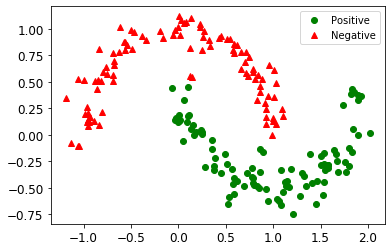

In [44]:
y_pred = (y_proba_val >= 0.5)          # binary classification
print(precision_score(y_test, y_pred)) # precision on test set
print(recall_score(y_test, y_pred))    # recall on test set
y_pred_idx = y_pred.reshape(-1)        # bring predictions in the right shape
# plot the predictions
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Now, we also play around with some hyperparameters, which is the last item on our to-do list. The "reciprocal" function from "scipy.stats" is usefule when exploring an unknown parameter range. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.reciprocal.html for details.

In [45]:
# use the reciprocal function for efficient random exploration of a vast parameter range
# link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.reciprocal.html
from scipy.stats import reciprocal
# determine the number of training iterations and loop through them
n_search_iterations = 10
for search_iteration in range(n_search_iterations):
    # determine characteristics of the current training iterations (some of them are random)
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)
    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    # show characteristics of the current training iteration
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")
    # reset the graph and build a new one (including a file writer)
    reset_graph()
    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    # number of epochs and batches
    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))
    # file path for the final model (note the dependence on "search_iteration")
    final_model_path = "./tf_logs/9_TF/my_logreg_model_%d" % search_iteration
    # run a tf session
    with tf.Session() as sess:
        sess.run(init)
        # loop through epochs
        for epoch in range(n_epochs):
            # loop through batches
            for batch_index in range(n_batches):
                # build a mini-batch and feed it to the algorithm so it can make a training step
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # get a summary and save it ("loss_val" is not used below)
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            # print a dot every 500 epochs without changing the line
            if epoch % 500 == 0:
                print(".", end="")
        # save the final model
        saver.save(sess, final_model_path)
        # make predictions
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        # go to a new line and then print precision and recall scors
        print()
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/9_TF/logreg-exercise-20190919134554/
  batch size: 54
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/9_TF/logreg-exercise-20190919135503/
  batch size: 22
  learning_rate: 0.0017826497151386947
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 2
  logdir: tf_logs/9_TF/logreg-exercise-20190919141355/
  batch size: 74
  learning_rate: 0.00203228544324115
  training: .....................
  precision: 0.9696969696969697
  recall: 0.9696969696969697
Iteration 3
  logdir: tf_logs/9_TF/logreg-exercise-20190919141925/
  batch size: 58
  learning_rate: 0.004491523825137997
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/9_TF/logreg-exercise-20190919142629/
  batch size: 61
  learning_rate: 0.07963234721775589
  training:

The above output may help with finding hyperparamters that return good results.